# Midterm Project

## Section 1: Business Understanding

##### Article 1: http://iopscience.iop.org/article/10.1088/1742-6596/1000/1/012100/pdf

1. This article talks about the methods of analysis that this group of researchers used to analyze data from IMDB so that they could try to predict the success of movies that come out in the future. Some of the questions they tried to answer were if a certain actor or actress appearing in the film was likely to help or hurt the film, if budget played a role in determining the success of a movie, or if the director of the film made a difference.

2. The text mining methods used in this analysis were SVMs and Bayesian Belief Networks.


##### Article 2: http://usir.salford.ac.uk/18838/1/Wessex_movie.pdf:public

1. This article discusses much of the same topics covered in article 1, namely what factors are or are not predictors of a movie's success. They came to the same conclusions, that films have decreased in quality over time, and that the actors and directors involved in the movie matter, and that the budget is no indication of the success of the movie.

2. They used decision tree clasifiers to predict if a movie was successful or not based on their own predefined criteria.

##### Article 3: https://rstudio-pubs-static.s3.amazonaws.com/312312_84d8c79cbf59427a865aa5185593360a.html

1. This person performed their analysis in R, and they also came to the same conclusions as the other two articles and they tried to answer the same questions as well.

2. The techniques that this person used were some that we have used in class, including wordcloud analysis and word frequency analysis.

## Section 2: Data Understanding


In [3]:
#Importing the necessary libraries
import requests
from lxml import html
import csv
import pandas as pd
import re
from PIL import Image
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pattern.en import sentiment
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Reading in the data
df = pd.read_csv('data/movie_metadata.csv')
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [5]:
df.rename(columns={'movie_title':'movie'},inplace=True)

In [6]:
df = df[['movie','imdb_score']]

In [7]:
df['movie'] = df['movie'].str.lower()

In [8]:
#Checking the 25 best movie titles so I can get the urls

df[['movie', 'imdb_score']].sort_values(by=['imdb_score'], ascending=False).head(25)

,movie,imdb_score
2765,towering inferno,9.5
1937,the shawshank redemption,9.3
3466,the godfather,9.2
4409,kickboxer: vengeance,9.1
2824,dekalog,9.1
3207,dekalog,9.1
66,the dark knight,9.0
2837,the godfather: part ii,9.0
3481,fargo,9.0
339,the lord of the rings: the return of the king,8.9


In [9]:
#Checking the 25 worst movie titles so I can get the urls

df[['movie', 'imdb_score']].sort_values(by=['imdb_score'], ascending=False).tail(25)

,movie,imdb_score
1702,dragonball: evolution,2.7
1654,meet the spartans,2.7
2182,date movie,2.7
4133,30 nights of paranormal activity with the devi...,2.6
4525,the vatican exorcisms,2.6
2852,baby geniuses,2.5
4874,sunday school musical,2.5
495,battlefield earth,2.4
899,gigli,2.4
3525,chairman of the board,2.3


### Section 2.1: Collecting the Reviews from the 25 best movies

In [8]:
from selenium import webdriver
import time
driver = webdriver.Firefox()

# multiple urls --> you can read multiple urls from csv file as well
posurls = ['tt0111161', 'tt0068646', 'tt0071562', 'tt0468569', 'tt0167260', 'tt0060196', 'tt0108052', 'tt0110912',
       'tt0120737', 'tt0080684', 'tt1375666', 'tt0109830', 'tt0137523', 'tt0133093', 'tt0167261', 'tt0076759',
          'tt0047478', 'tt0073486', 'tt0099685', 'tt0317248', 'tt0114814', 'tt0102926', 'tt0245429', 'tt0114369',
          'tt0120815']

pos_data = []

### The movie line below works, as does all of the xpath code in quotations, now I just need to run this on windows
### with firefox and then the positive movie data will be collected


for url in posurls:

    driver.get("https://www.imdb.com/title/" + url + "/reviews?ref_=tt_urv")
    spoilers = driver.find_element_by_class_name("faceter-facets-text")
    spoilers.click()
    next_button = driver.find_element_by_class_name("ipl-load-more__button")
    next_button.click()
    movie = driver.find_element_by_xpath("//h3[@itemprop='name']/a").text.encode('utf-8')


    for review in driver.find_elements_by_xpath("//div[@class='lister-item-content']"):
        summary = review.find_element_by_xpath("div[@class='content']/div[1]").text.encode('utf-8')
        reviewtitle = review.find_element_by_xpath("a").text.encode('utf-8')
        pos_data.append([movie, reviewtitle, summary])
        
    time.sleep(3)
        
   


In [9]:
len(pos_data)

671

In [10]:
pos_data[1]

['The Shawshank Redemption',
 'Prepare to be moved',
 "I have never seen such an amazing film since I saw The Shawshank Redemption. Shawshank encompasses friendships, hardships, hopes, and dreams. And what is so great about the movie is that it moves you, it gives you hope. Even though the circumstances between the characters and the viewers are quite different, you don't feel that far removed from what the characters are going through.\n\nIt is a simple film, yet it has an everlasting message. Frank Darabont didn't need to put any kind of outlandish special effects to get us to love this film, the narration and the acting does that for him. Why this movie didn't win all seven Oscars is beyond me, but don't let that sway you to not see this film, let its ranking on the IMDb's top 250 list sway you, let your friends recommendation about the movie sway you.\n\nSet aside a little over two hours tonight and rent this movie. You will finally understand what everyone is talking about and you

In [11]:
posdf = pd.DataFrame(pos_data)

posdf.head()

,0,1,2
0,The Shawshank Redemption,Tied for the best movie I have ever seen,Why do I want to write the 234th comment on Th...
1,The Shawshank Redemption,Prepare to be moved,I have never seen such an amazing film since I...
2,The Shawshank Redemption,This is How Movies Should Be Made,This movie is not your ordinary Hollywood flic...
3,The Shawshank Redemption,Shawshank Redeems Hollywood,"Can Hollywood, usually creating things for ent..."
4,The Shawshank Redemption,Don't Rent Shawshank.,I'm trying to save you money; this is the last...


### Section 2.2: Collecting reviews from the 25 worst movies

In [16]:
from selenium import webdriver
import time
driver = webdriver.Firefox()

# multiple urls --> you can read multiple urls from csv file as well
negurls = ['tt0462244', 'tt0383222', 'tt0120207', 'tt0266747', 'tt0093300', 'tt0763304', 'tt0120598', 'tt0360916',
          'tt1073498', 'tt1098327', 'tt0466342', 'tt0118665', 'tt0299930', 'tt0185183', 'tt0799949', 'tt0118836',
          'tt0083542', 'tt0362165', 'tt0118589', 'tt0339034', 'tt0473024', 'tt0785077','tt0270846', 'tt1213644',
          'tt1702443']

neg_data = []

### The movie line below works, as does all of the xpath code in quotations, now I just need to run this on windows
### with firefox and then the positive movie data will be collected


for url in negurls:

    driver.get("https://www.imdb.com/title/" + url + "/reviews?ref_=tt_urv")
    spoilers = driver.find_element_by_class_name("faceter-facets-text")
    spoilers.click()
    next_button = driver.find_element_by_class_name("ipl-load-more__button")
    next_button.click()
    movie = driver.find_element_by_xpath("//h3[@itemprop='name']/a").text.encode('utf-8')


    for review in driver.find_elements_by_xpath("//div[@class='lister-item-content']"):
        summary = review.find_element_by_xpath("div[@class='content']/div[1]").text.encode('utf-8')
        reviewtitle = review.find_element_by_xpath("a").text.encode('utf-8')
        neg_data.append([movie, reviewtitle, summary])
        
    time.sleep(3)
        
   


In [17]:
len(neg_data)

730

In [18]:
neg_data[1]

['Daddy Day Camp',
 'Not bad enough to be on the bottom 100 of IMDb, but still pretty bad.',
 "Daddy Day Care was a sweet and simple movie that I enjoyed quite a bit actually, I really don't think it needed a sequel of any sorts. As you may have seen in many of my reviews for his films, I am a huge Cuba Gooding Jr. fan and he is MUCH better than the turds like this that he is producing now a days. I will say I expected much worse, so that's a compliment I can give it I suppose. The really sad thing about this movie is that it's obvious Cuba is trying his heart out for this movie to be good. He's no Eddie Murphy but his effort his very much appreciated, I just wish it was in a much better movie. The kids have no depth to them, they're annoying and they certainly can't act, they look like that just kids. It's a film of unfunny gags for toddlers, and it just has no real heart or soul to the movie other than the relationship of Cuba, his son and Cuba's father which is superbly played by Ri

In [19]:
negdf = pd.DataFrame(neg_data)
negdf.head()


,0,1,2
0,Daddy Day Camp,God-awful Family Film with Little to Offer,After sitting through the entirety of Daddy Da...
1,Daddy Day Camp,Not bad enough to be on the bottom 100 of IMDb...,Daddy Day Care was a sweet and simple movie th...
2,Daddy Day Camp,Average movie..definitely NOT worst in the his...,"This is my first comment on IMDb, because i am..."
3,Daddy Day Camp,simply a horrible idea,This movie was just awful. The plot is 2 guys ...
4,Daddy Day Camp,"All in all, it's still terrible...","Really, I'm only commenting because the origin..."


### Section 2.3: Quick summary of the data

In [20]:
# Total number of reviews for top 25 movies
len(posdf)

671

In [21]:
# Total number of reviews for worst 25 movies
len(negdf)

730

In [22]:
# Total number of reviews for all movies collected
len(posdf) + len(negdf)

1401

In [23]:
posdf.to_csv('top_reviews.csv')
negdf.to_csv('worst_reviews.csv')

In [24]:
# Number of reviews per movie for top 25 movies

posdf.groupby(posdf[0]).size()

movie
City of God                                          24
Fight Club                                           25
Forrest Gump                                         25
Goodfellas                                           50
Inception                                            50
One Flew Over the Cuckoo's Nest                      25
Pulp Fiction                                         25
Saving Private Ryan                                  25
Schindler's List                                     25
Se7en                                                25
Seven Samurai                                        25
Spirited Away                                        25
Star Wars: Episode IV - A New Hope                   24
Star Wars: Episode V - The Empire Strikes Back       25
The Dark Knight                                      25
The Godfather                                        25
The Godfather: Part II                               25
The Good, the Bad and the Ugly            

In [25]:
# Number of reviews per movie for worst 25 movies

negdf.groupby(negdf[0]).size()

movie
Alone in the Dark                 25
Baby Geniuses                     25
Barney's Great Adventure          40
Battlefield Earth                 24
BloodRayne                        50
Chairman of the Board             50
Crossover                         25
Daddy Day Camp                    27
Date Movie                        25
Disaster Movie                    25
Doogal                            25
Dragonball: Evolution             25
Epic Movie                        25
From Justin to Kelly              50
Gigli                             25
Glitter                           25
Jaws: The Revenge                 25
Justin Bieber: Never Say Never    25
Marci X                           25
Meet the Spartans                 25
Son of the Mask                   25
Steel                             25
Superbabies: Baby Geniuses 2      25
The Real Cancun                   25
Who's Your Caddy?                 39
dtype: int64

## Section 3: Data Cleaning and Preprocessing

### Section 3.1: Cleaning the reviews for the 25 best movies

In [10]:
posdf = pd.read_csv('data/top_reviews.csv', index_col=0)
posdf.head()

,0,1,2
0,The Shawshank Redemption,Tied for the best movie I have ever seen,Why do I want to write the 234th comment on Th...
1,The Shawshank Redemption,Prepare to be moved,I have never seen such an amazing film since I...
2,The Shawshank Redemption,This is How Movies Should Be Made,This movie is not your ordinary Hollywood flic...
3,The Shawshank Redemption,Shawshank Redeems Hollywood,"Can Hollywood, usually creating things for ent..."
4,The Shawshank Redemption,Don't Rent Shawshank.,I'm trying to save you money; this is the last...


In [11]:
posdf = posdf.rename(columns={'0':'movie', '1':'review_title', '2':'review'})

In [12]:
posdf['movie'] = posdf['movie'].str.lower()
posdf['review_title'] = posdf['review_title'].str.lower()
posdf['review'] = posdf['review'].str.lower()

In [13]:
posdf['movie'] = posdf['movie'].str.replace("[^a-zA-Z0-9]", " ")
posdf['review_title'] = posdf['review_title'].str.replace("[^a-zA-Z0-9]", " ")
posdf['review'] = posdf['review'].str.replace("[^a-zA-Z0-9]", " ")

In [14]:
#Remove short words
posdf['review'] = posdf['review'].str.findall('\w{3,}').str.join(' ')
posdf.head()

,movie,review_title,review
0,the shawshank redemption,tied for the best movie i have ever seen,why want write the 234th comment the shawshank...
1,the shawshank redemption,prepare to be moved,have never seen such amazing film since saw th...
2,the shawshank redemption,this is how movies should be made,this movie not your ordinary hollywood flick h...
3,the shawshank redemption,shawshank redeems hollywood,can hollywood usually creating things for ente...
4,the shawshank redemption,don t rent shawshank,trying save you money this the last film title...


In [15]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords = set(stopwords)
stopwords.add('film')
stopwords.add('movie')
stopwords.add('one')
stopwords.add('even')
stopwords.add('really')
stopwords.add('time')
stopwords.add('title')
stopwords.add('first')
stopwords.add('last')
stopwords.add('don')
stopwords.add('could')
stopwords.add('many')
stopwords.add('much')
stopwords.add('also')
stopwords.add('might')
stopwords.add('should')
stopwords.add('films')
stopwords.add('movies')
stopwords.add('way')
stopwords.add('ever')
stopwords.add('would')

posdf['review'] = posdf['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

### Section 3.2: Cleaning the reviews for the worst 25 movies

In [16]:
negdf = pd.read_csv('data/worst_reviews.csv', index_col=0)
negdf.head()

,0,1,2
0,Daddy Day Camp,God-awful Family Film with Little to Offer,After sitting through the entirety of Daddy Da...
1,Daddy Day Camp,Not bad enough to be on the bottom 100 of IMDb...,Daddy Day Care was a sweet and simple movie th...
2,Daddy Day Camp,Average movie..definitely NOT worst in the his...,"This is my first comment on IMDb, because i am..."
3,Daddy Day Camp,simply a horrible idea,This movie was just awful. The plot is 2 guys ...
4,Daddy Day Camp,"All in all, it's still terrible...","Really, I'm only commenting because the origin..."


In [17]:
negdf = negdf.rename(columns={'0':'movie', '1':'review_title', '2':'review'})

In [18]:
negdf['movie'] = negdf['movie'].str.lower()
negdf['review_title'] = negdf['review_title'].str.lower()
negdf['review'] = negdf['review'].str.lower()

In [19]:
negdf['movie'] = negdf['movie'].str.replace("[^a-zA-Z0-9]", " ")
negdf['review_title'] = negdf['review_title'].str.replace("[^a-zA-Z0-9]", " ")
negdf['review'] = negdf['review'].str.replace("[^a-zA-Z0-9]", " ")

In [20]:
negdf['review'] = negdf['review'].str.findall('\w{3,}').str.join(' ')
negdf.head()

,movie,review_title,review
0,daddy day camp,god awful family film with little to offer,after sitting through the entirety daddy day c...
1,daddy day camp,not bad enough to be on the bottom 100 of imdb...,daddy day care was sweet and simple movie that...
2,daddy day camp,average movie definitely not worst in the his...,this first comment imdb because not very good ...
3,daddy day camp,simply a horrible idea,this movie was just awful the plot guys who ru...
4,daddy day camp,all in all it s still terrible,really only commenting because the original mo...


In [21]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords = set(stopwords)
stopwords.add('film')
stopwords.add('movie')
stopwords.add('one')
stopwords.add('even')
stopwords.add('really')
stopwords.add('time')
stopwords.add('title')
stopwords.add('first')
stopwords.add('last')
stopwords.add('don')
stopwords.add('could')
stopwords.add('many')
stopwords.add('much')
stopwords.add('also')
stopwords.add('might')
stopwords.add('should')
stopwords.add('films')
stopwords.add('movies')
stopwords.add('way')
stopwords.add('ever')
stopwords.add('would')


negdf['review'] = negdf['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

## Section 4: Business Intelligence

### Section 4.a: Descriptive Text Analytics

#### Section 4.a.1: Descriptive Text Analytics for top 25 movies

In [22]:
topsents = []

for index, row in posdf.iterrows():
    topsents.append(posdf['review'][index])

In [23]:
scores = []
for row in topsents:
    score = sentiment(row)
    scores.append(score[0])
    
print scores[:5]

[0.41791979949874686, 0.3264030612244898, 0.3055361305361305, 0.236629045557617, 0.21454311454311456]


In [24]:
posdf['sentiment'] = scores

In [25]:
posdf['sentiment'].describe()

count    671.000000
mean       0.175336
std        0.166653
min       -0.341759
25%        0.081391
50%        0.168768
75%        0.263795
max        0.787500
Name: sentiment, dtype: float64

In [26]:
# This is the code I used to generate the 'best' variable originally, I had to save it as its own data file to get things
# to work correctly

#best = df[['movie', 'imdb_score']].sort_values(by=['imdb_score'], ascending=False).head(25)
#best['movie'] = best['movie'].str.lower()

In [27]:
#best.to_csv('best25movies.csv', index=False)

In [28]:
best = pd.read_csv('data/best25movies.csv')

In [29]:
best.head()

,movie,imdb_score
0,the shawshank redemption,9.3
1,the godfather,9.2
2,the dark knight,9.0
3,the godfather: part ii,9.0
4,the lord of the rings: the return of the king,8.9


In [30]:
best['movie'] = best['movie'].str.replace('\xc2\xa0', '')

In [31]:
best['movie'][0]

'the shawshank redemption'

In [32]:
posdf = pd.merge(posdf, best, how='left', on='movie')
posdf.head()

,movie,review_title,review,sentiment,imdb_score
0,the shawshank redemption,tied for the best movie i have ever seen,want write 234th comment shawshank redemption ...,0.417920,9.3
1,the shawshank redemption,prepare to be moved,never seen amazing since saw shawshank redempt...,0.326403,9.3
2,the shawshank redemption,this is how movies should be made,ordinary hollywood flick great deep message fo...,0.305536,9.3
3,the shawshank redemption,shawshank redeems hollywood,hollywood usually creating things entertainmen...,0.236629,9.3
4,the shawshank redemption,don t rent shawshank,trying save money consider borrowing renting s...,0.214543,9.3


In [33]:
posdf['wordcounts'] = posdf['review'].str.split()
posdf['wordcount'] = posdf.wordcounts.str.len()
posdf.drop('wordcounts',axis=1, inplace=True)

In [34]:
#Average number of words in the reviews for the top 25 movies
posdf['wordcount'].mean()

152.50074515648285

In [35]:
# Word Frequency Analysis for top 25 movies: top 15 most common words

from collections import Counter

fdist = Counter(" ".join(posdf['review']).split(" ")).items()

freq_word = []

for k,v in fdist:
    freq_word.append([k,v])

wordlist = pd.DataFrame(freq_word)
wordlist.sort_values(by=1, ascending=False).head(15)

,0,1
10050,like,667
12347,story,555
2638,great,513
11733,good,494
478,best,471
2170,see,458
6562,well,454
10850,characters,423
688,people,409
13618,made,341


In [38]:
wordlist = wordlist.rename(columns={0:'word', 1:'count'})
wordlist.head(1)

,word,count
0,fawn,1


In [41]:
wordlist.set_index('word',inplace=True)

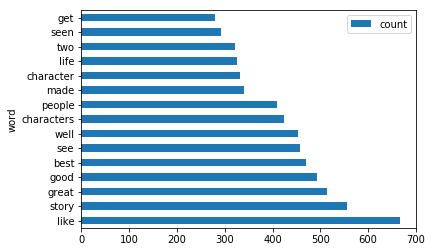

In [43]:
wordlist.sort_values(by='count', ascending=False).head(15).plot(kind='barh')

In [44]:
#Classifying reviews as positive, neutral, or negative to see how many are in each class

positive_review = []
negative_review = []
neutral_review = []

for review in topsents:
    rev = review
    score = sentiment(rev)
    if score[0] > 0:
        positive_review.append([rev,score])
    elif score[0] == 0:
        neutral_review.append([rev,score])
    else:
        negative_review.append([rev,score])

In [45]:
num_pos = len(positive_review)
num_neu = len(neutral_review)
num_neg = len(negative_review)

In [46]:
print "The number of positive reviews is: {}".format(num_pos)
print "The number of neutral reviews is: {}".format(num_neu)
print "The number of negative reviews is: {}".format(num_neg) 

The number of positive reviews is: 594
The number of neutral reviews is: 2
The number of negative reviews is: 75


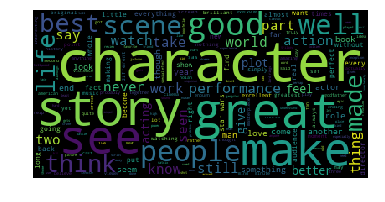

In [47]:
#Wordcloud analysis

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud().generate(' '.join(posdf['review']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Section 4.a.2: Descriptive Text Analytics for worst 25 movies

In [48]:
bottomsents = []

for index, row in negdf.iterrows():
    bottomsents.append(negdf['review'][index])

In [49]:
scores = []
for row in bottomsents:
    score = sentiment(row)
    scores.append(score[0])
    
print scores[:5]

[-0.07799603174603173, 0.08238916256157638, -0.2058333333333333, -0.15277777777777776, 0.10677083333333336]


In [50]:
negdf['sentiment'] = scores

In [51]:
negdf['sentiment'].describe()

count    730.000000
mean       0.017593
std        0.197919
min       -1.000000
25%       -0.107547
50%        0.016667
75%        0.138116
max        0.681481
Name: sentiment, dtype: float64

In [52]:
# This is the code I used to generate the 'worst' variable originally, I had to save it as its own data file to get things
# to work correctly

#worst = df[['movie', 'imdb_score']].sort_values(by=['imdb_score'], ascending=False).tail(25)
#worst['movie'] = worst['movie'].str.lower()
#worst.head(1)

In [53]:
#worst.to_csv('worst25movies.csv', index=False)

In [54]:
worst = pd.read_csv('data/worst25movies.csv')
worst.head(2)

,movie,imdb_score
0,daddy day camp,2.9
1,bloodrayne,2.9


In [55]:
worst['movie'][0]

'daddy day camp\xc2\xa0'

In [56]:
worst['movie'] = worst['movie'].str.replace('\xc2\xa0', '')

In [57]:
worst['movie'][0]

'daddy day camp'

In [58]:
negdf = pd.merge(negdf, worst, how='left', on='movie')
negdf.head()

,movie,review_title,review,sentiment,imdb_score
0,daddy day camp,god awful family film with little to offer,sitting entirety daddy day camp wonder going e...,-0.077996,2.9
1,daddy day camp,not bad enough to be on the bottom 100 of imdb...,daddy day care sweet simple enjoyed quite bit ...,0.082389,2.9
2,daddy day camp,average movie definitely not worst in the his...,comment imdb good english seeing underrated ca...,-0.205833,2.9
3,daddy day camp,simply a horrible idea,awful plot guys run day care decide take day c...,-0.152778,2.9
4,daddy day camp,all in all it s still terrible,commenting original useful comment idiotic pra...,0.106771,2.9


In [59]:
negdf['wordcounts'] = negdf['review'].str.split()
negdf['wordcount'] = negdf.wordcounts.str.len()
negdf.drop('wordcounts',axis=1, inplace=True)

In [60]:
negdf['wordcount'].mean()

100.17260273972603

In [61]:
# Word Frequency Analysis for bottom 25 movies: top 15 most common words

from collections import Counter

fdist = Counter(" ".join(negdf['review']).split(" ")).items()

freq_word = []

for k,v in fdist:
    freq_word.append([k,v])

wordlist = pd.DataFrame(freq_word)
wordlist.sort_values(by=1, ascending=False).head(15)

,0,1
8493,like,732
2413,bad,561
9890,good,490
1852,see,417
588,people,331
9046,watch,289
11462,made,288
6718,think,285
6214,make,282
6836,get,281


In [62]:
wordlist = wordlist.rename(columns={0:'word', 1:'count'})
wordlist.head(1)

,word,count
0,raining,2


In [63]:
wordlist.set_index('word',inplace=True)

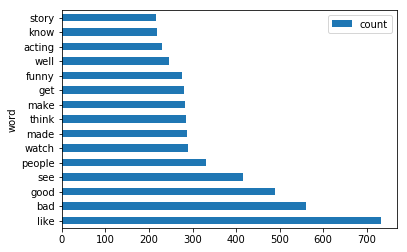

In [64]:
wordlist.sort_values(by='count', ascending=False).head(15).plot(kind='barh')

In [65]:
#Classifying reviews as positive, neutral, or negative to see how many are in each class

positive_review = []
negative_review = []
neutral_review = []

for review in bottomsents:
    rev = review
    score = sentiment(rev)
    if score[0] > 0:
        positive_review.append([rev,score])
    elif score[0] == 0:
        neutral_review.append([rev,score])
    else:
        negative_review.append([rev,score])

In [66]:
num_pos = len(positive_review)
num_neu = len(neutral_review)
num_neg = len(negative_review)

In [67]:
print "The number of positive reviews is: {}".format(num_pos)
print "The number of neutral reviews is: {}".format(num_neu)
print "The number of negative reviews is: {}".format(num_neg) 

The number of positive reviews is: 402
The number of neutral reviews is: 0
The number of negative reviews is: 328


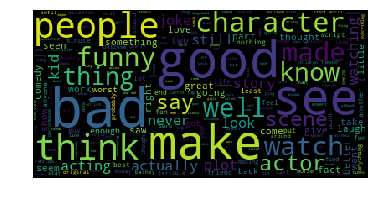

In [68]:
#Wordcloud analysis

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud().generate(' '.join(negdf['review']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##### Section 4.a.3: Quick discussion of the results of descriptive text analytics 

##### Based on our analysis thus far, we can see a few important things in our data:

        1. The average review length for the top 25 movies was about 150 words, and the average review lenght for 
           the worst 25 movies was only about a hundred words. This tells us that if a review is longer, it is 
           more likely to be on a movie that has a higher imdb score, which would be usefull for predicting future
           movie success. If our movie just came out, and we are seeing longer reviews, we can take that as sign
           that our movie will likely be positively recieved by the public, meaning that it will likely be more
           profitable at the box office.
           
        2. From the word cloud and word frequency analysis, we can see that the most common words in the best 25 movies
           were "like", "story", "great", and "character." This gives us some insights into what factors might make 
           a movie great, or what might make people respond more positvely to a movie. If a movie has a really good
           story and well developed characters, it will likely be more successful and profitable than movies that lack
           story and character development. 
           
           One of the things that stood out to me about the wordcloud and word frequency analysis of the worst 25 movies
           was that it was a mixed bag of reviews, with a lot of people saying good, and a lot of people saying bad. 
           Another interesting bit of information that we can see in the word cloud of the worst 25 movies is the word
           funny. This could be important as it might indicate that movies that are in the comedy genre might have a 
           lower imdb score than movies in other genres.

### Section 4.b: Sentiment Analysis

#### Section 4.b.1: Predicting top 25 movie success using review sentiments

In [69]:
#Im going to use correlation and regression to determine if sentiment is a good predictor of imdb score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [70]:
posdf.corr()

,sentiment,imdb_score,wordcount
sentiment,1.000000,0.124609,-0.092312
imdb_score,0.124609,1.000000,-0.031524
wordcount,-0.092312,-0.031524,1.000000


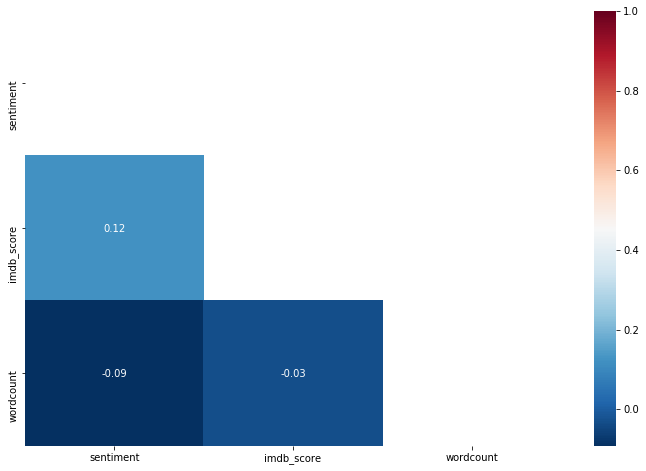

In [74]:
plt.figure(figsize=[12,8])

poscorr= posdf.corr()

mask = np.zeros_like(poscorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(poscorr, mask=mask, cmap='RdBu_r', annot=True, fmt='.2f')

In [80]:
sent_reg_model1 = ols("imdb_score~sentiment",posdf)
sent_reg1 = sent_reg_model1.fit()
print sent_reg1.summary()

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     6.656
Date:                Fri, 12 Oct 2018   Prob (F-statistic):             0.0102
Time:                        12:27:05   Log-Likelihood:                 87.029
No. Observations:                 424   AIC:                            -170.1
Df Residuals:                     422   BIC:                            -162.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7699      0.013    650.312      0.0

#### Section 4.b.1.1 Quick Discussion of Regression analysis of top 25 movies

##### So from our ANOVA output, we can see that sentiment is a statistically significant predictor of imdb scores for the top 25 movies, and we can see that our overall model is statistically significant, however, our R-squared value is incredibly low, and this model only explains 1.6% of the total variation between imdb scores. We can thus say that sentiment anlaysis alone is not enough to predict the future success of a movie in terms of imdb_score.

#### Section 4.b.2: Predicting worst 25 movie success using review sentiments

In [82]:
#Im going to use correlation and regression to determine if sentiment is a good predictor of imdb score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [83]:
negdf.corr()

,sentiment,imdb_score,wordcount
sentiment,1.000000,0.055581,-0.006195
imdb_score,0.055581,1.000000,-0.079430
wordcount,-0.006195,-0.079430,1.000000


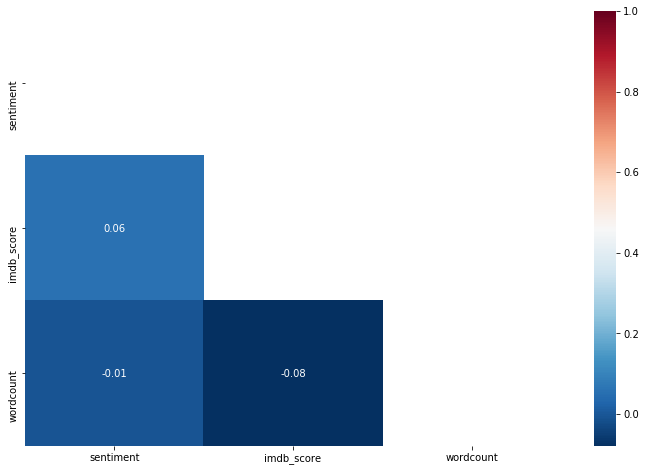

In [84]:
plt.figure(figsize=[12,8])

negcorr = negdf.corr()

mask = np.zeros_like(negcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(negcorr, mask=mask, cmap='RdBu_r', annot=True, fmt='.2f')

In [85]:
sent_reg_model2 = ols("imdb_score~sentiment",negdf)
sent_reg2 = sent_reg_model2.fit()
print sent_reg2.summary()

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.701
Date:                Fri, 12 Oct 2018   Prob (F-statistic):              0.193
Time:                        12:36:57   Log-Likelihood:                -136.68
No. Observations:                 551   AIC:                             277.4
Df Residuals:                     549   BIC:                             286.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4650      0.013    186.221      0.0

#### Section 4.b.2.1: Quick discussion of Regression analysis of worst 25 movie sentiments

##### Interestingly enough, we see a different result when we analyze the review sentiments of the worst 25 movies. Neither our predictor, review sentiment, nor our overall model, are statistically significant. Our R-squared value is 0.003, which means review sentiments only explain 0.03% of the variation between imdb_scores. This means that we cant really make any useful inferences about a movies future success based on a review's sentiment.

#### Section 4.b.3: Predicting movie score for both top 25 and worst 25 movies combined

In [86]:
len(posdf)

671

In [87]:
len(negdf)

730

In [90]:
frames = [posdf,negdf]

bothdf = pd.concat(frames)

In [91]:
len(bothdf)

1401

In [92]:
#Im going to use correlation and regression to determine if sentiment is a good predictor of imdb score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [93]:
bothdf.corr()

,sentiment,imdb_score,wordcount
sentiment,1.000000,0.409020,0.054741
imdb_score,0.409020,1.000000,0.189581
wordcount,0.054741,0.189581,1.000000


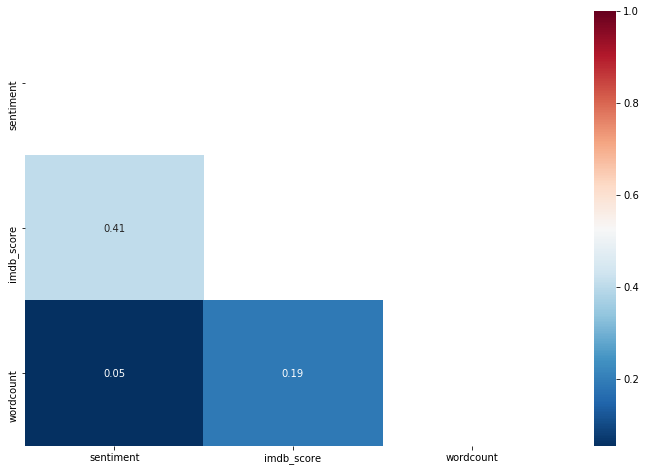

In [94]:
plt.figure(figsize=[12,8])

bothcorr = bothdf.corr()

mask = np.zeros_like(bothcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(bothcorr, mask=mask, cmap='RdBu_r', annot=True, fmt='.2f')

In [95]:
sent_reg_model3 = ols("imdb_score~sentiment",bothdf)
sent_reg3 = sent_reg_model3.fit()
print sent_reg3.summary()

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     195.5
Date:                Fri, 12 Oct 2018   Prob (F-statistic):           1.30e-40
Time:                        12:58:07   Log-Likelihood:                -2412.6
No. Observations:                 975   AIC:                             4829.
Df Residuals:                     973   BIC:                             4839.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7368      0.098     48.172      0.0

##### Section 4.b.3.1: Discussion of Joint Regression analysis of top 25 and worst 25 movie sentiments

##### The results of the regression analysis of the joint datasets yeilds interesting results. We see that like the analysis of the top 25 movie sentiments, here too sentiment is a statistically significant predictor of imdb_score, and our overall model is statistically significant, yet still our R-squared value is very low, here only 0.167, meaning that using sentiment as our sole predictor of a movie's imdb score only explains 16.7% of the variation in imdb scores. Our coefficients here also changed dramatically, with sentiment having a higher magnitude of influence on the IMDB Score.

## Section 5: Storytelling and Summary of Results

### We have been able to glean some very important and interesting insights from our analysis of review sentiments, and the results are as follows:


        1. Movies with higher IMDb scores tended to have on average reviews that had a higher sentiment score
           than those with a lower score, meaning the top 25 movies were more likely to have reviews that 
           were more positive, while the worst 25 movies were more likely to have reviews that were 
           not so positive. We also saw that the average review for the top 25 movies contained about
           150 words, where as the average review for the worst 25 movies was only about 100 words long.
           
        2. We learned that the content of a movie matters, not so much in terms of genre, but in terms of story 
           and character development. Some of the most common words for the top 25 movies were about characters
           and story, and from the word cloud it looks like movies that have very interesting stories and 
           characters that are deep and complex and developed tended to have reviews that had a higher 
           sentiment score. 
           
           Interestingly enough however, for the worst 25 movies, it did seem that genre might have played
           a role in determining score, as the word "funny" was one of the most common words in that set
           of reviews. This makes sense based on our analysis of the 25 best movies, as many of those movies
           had complex and rich stories with well developed characters, whereas comedy movies tend to lack
           such elements, which might explain why they receive lower scoring sentiments in their reviews, as 
           well as possibly lower imdb scores.
            
        3. Based on our regression analysis, when we analyzed the data separately, we got some different yet
           still interesting results. The analysis of the top 25 movies shows that while sentiment is a 
           statistically significant predictor of imdb score, it fails to explain a lot of the variation
           between imdb scores. When we analyzed the worst 25 movies, sentiment score wasnt even significant,
           nor was the overall model significant, and almost none of the variation in imdb scores was explained,
           however, when we analyzed both datasets togther, we saw that sentiment was even more significant of
           a predictor than in either of the separate regression models, and that the magnitude of its coefficient
           had increased substantially. 
           
           We also saw that more of the varation between imdb scores was explained,
           however, it still was miniscule, and thus we cant really make any accurate or meaningful predictions
           about future movie scores based on this model alone that uses sentiment as the only predictor variable.
           Other factors must be included to get a more holistic picture of what makes a movie successful in terms
           of its imdb score.

##### On my honor as a student, I have neither given nor recieved any unauthorized aid on this academic work

Eric VanMeerhaeghe